<a href="https://colab.research.google.com/github/PranayBhargav/Advanced_Regression/blob/main/Pranay_NLP_NER_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#loading the data
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
100% 83.4M/83.4M [00:00<00:00, 159MB/s]


In [5]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


In [6]:
# opening the Dataframe to analyze
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [7]:
#inspecting the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#cleaning the column names
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns=lambda x: x.strip('_'), inplace=True)

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#taking backup of the Dataframe for further analysis
df_eda = df.copy(deep=True)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [10]:
#Filling the blank cells with nan for better understanding

df_eda['complaint_what_happened'] = np.where(df_eda['complaint_what_happened'] =='', np.nan, df_eda['complaint_what_happened'])
df_eda['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [11]:
#removing the rows with nan values
df_eda= df_eda[~df_eda.complaint_what_happened.isna()]
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Pre-process for  topic modeling


In [12]:
# analyzing the column "complaint_what_happened"
brackets = df_eda[df_eda.complaint_what_happened.str.contains('\[\s*\w*\s*\]')]
print("No of complaints with brackets = {}".format(len(brackets)))


No of complaints with brackets = 87


In [13]:
# Clean the columns and remove all the unnecessary elements.
def clean_text_column(text):
   text = text.lower()
   text = re.sub("\[\s*\w*\s*\]", "", text)
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = re.sub("\S*\d\S*", "", text)

   return text

df_eda.complaint_what_happened = pd.DataFrame(df_eda.complaint_what_happened.apply(lambda x: clean_text_column(x)))   

In [15]:
# Lemmatize the texts and  find the Pos Tags
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

In [16]:
#using a pip
## Using nlp pipes with chunking for faster execution 
def pos_lemmatize_pipe(doc):
    document_lemma = " ".join([tok.lemma_ for tok in doc])
    document_pos = " ".join([tok.text for tok in doc if tok.pos_ == 'NOUN']) 
    return document_lemma, document_pos

def spacy_pos_lemmatizer(texts):
    return [pos_lemmatize_pipe(doc) for doc in nlp.pipe(texts, batch_size=40, disable=["tok2vec", "parser", "ner"])]
    
df_eda['complaints_lemma'],  df_eda['complaints_pos_tags'] = zip(*spacy_pos_lemmatizer(df_eda.complaint_what_happened))

In [17]:
#modified Data Frame
df_clean = df_eda[['complaint_what_happened', 'complaints_lemma','complaints_pos_tags']].copy()

## Exploratory data analysis 


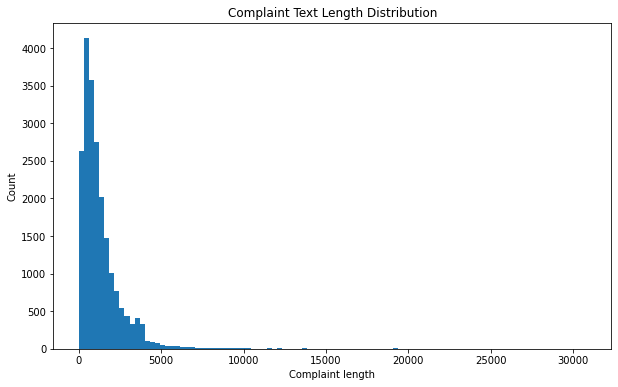

In [18]:
# complaint_column is visualized
df_clean['complaint_len'] = df_clean['complaint_what_happened'].astype(str).apply(len)

plt.figure(figsize=(10,6))
df_clean['complaint_len'].plot.hist(bins=100, title='Complaint Text Length Distribution')
plt.xlabel('Complaint length')
plt.ylabel('Count')
plt.show()


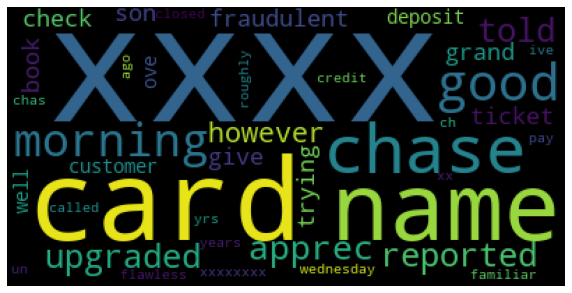

In [20]:
#finding the top 40 words by there frequency
#using the word cloud function
from wordcloud import WordCloud
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_what_happened))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


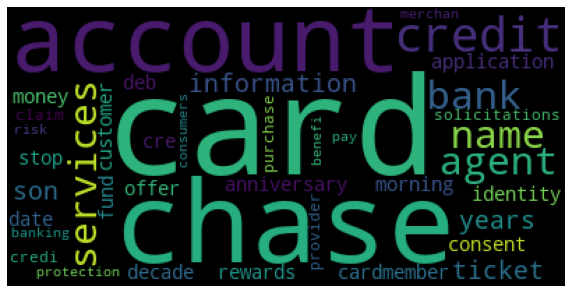

In [21]:
#usignt he word cloud function 
wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaints_pos_tags))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [23]:
#removing the POS Tag PRON
df_clean['complaint_clean'] = df_clean['complaints_lemma'].str.replace('-PRON-', '')
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember services deb...,475,good morning name be xxxx xxxx and i apprecia...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...,337,i upgrade xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card application identity consent services cre...,210,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket rewards card information o...,1433,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund bank account money son ...,456,grand son give check for i deposit into ...


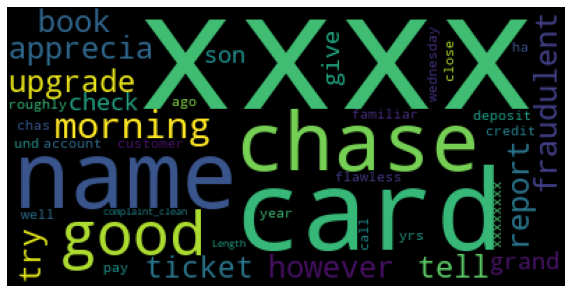

In [24]:
#Using a word cloud 
wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_clean))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [25]:
#finding the top unigram, bigram and trigram
#Function to return the top 'n' words from corpus for a given 'n_gram_range'
def get_top_n_ngram( corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

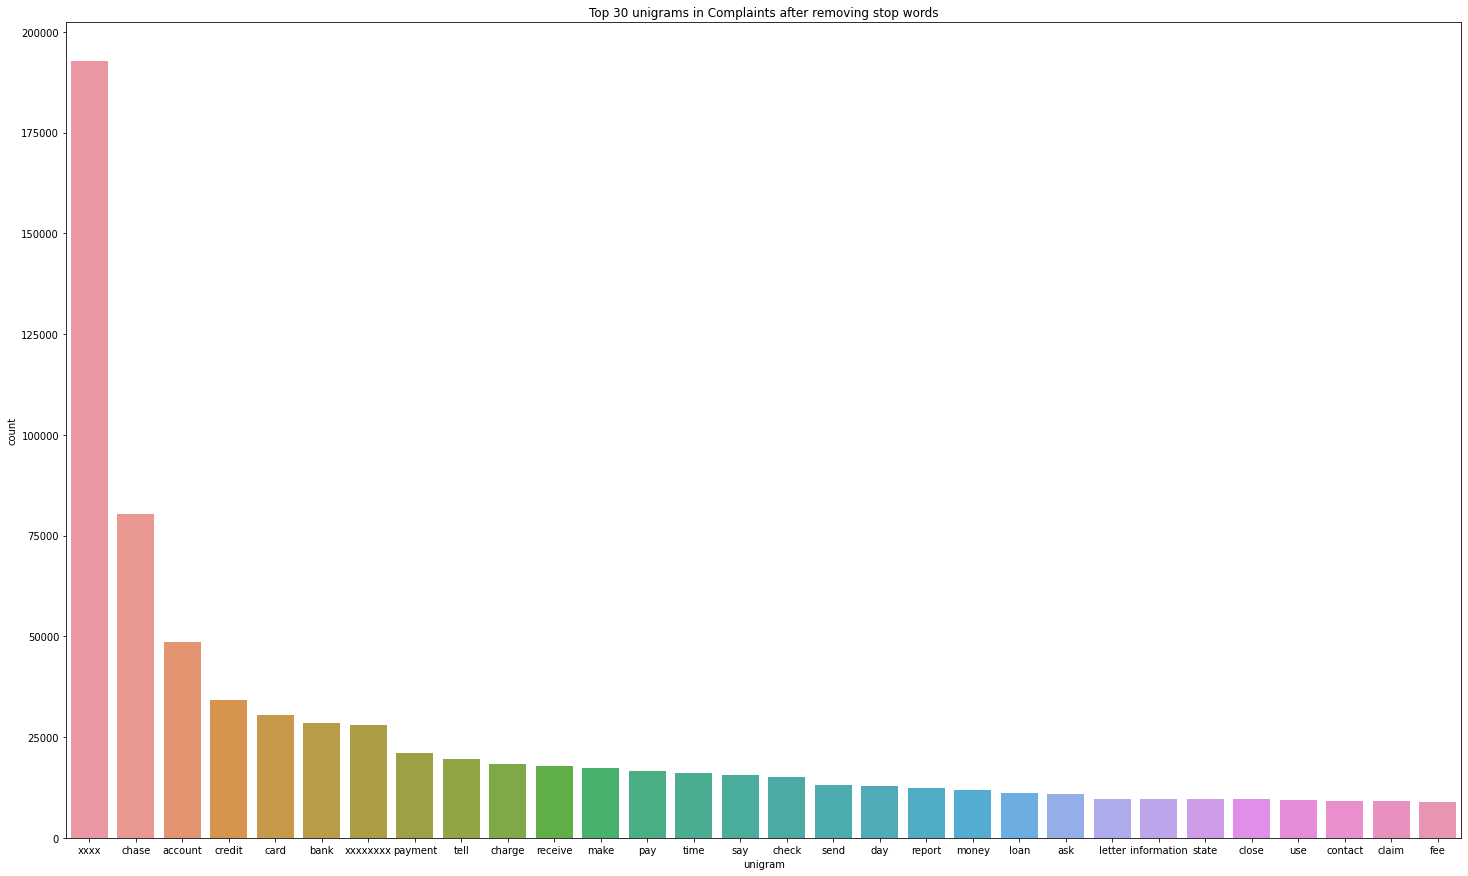

In [26]:
#top 30 unigram 
common_words = get_top_n_ngram(df_clean.complaint_clean, 1, 30)
df1 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=[25,15])
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.title('Top 30 unigrams in Complaints after removing stop words')
plt.show()

In [27]:
#inspecting the data of unigrams
df1.head(10)

,unigram,count
0,xxxx,192695
1,chase,80388
2,account,48671
3,credit,34155
4,card,30520
5,bank,28400
6,xxxxxxxx,27927
7,payment,21164
8,tell,19677
9,charge,18230


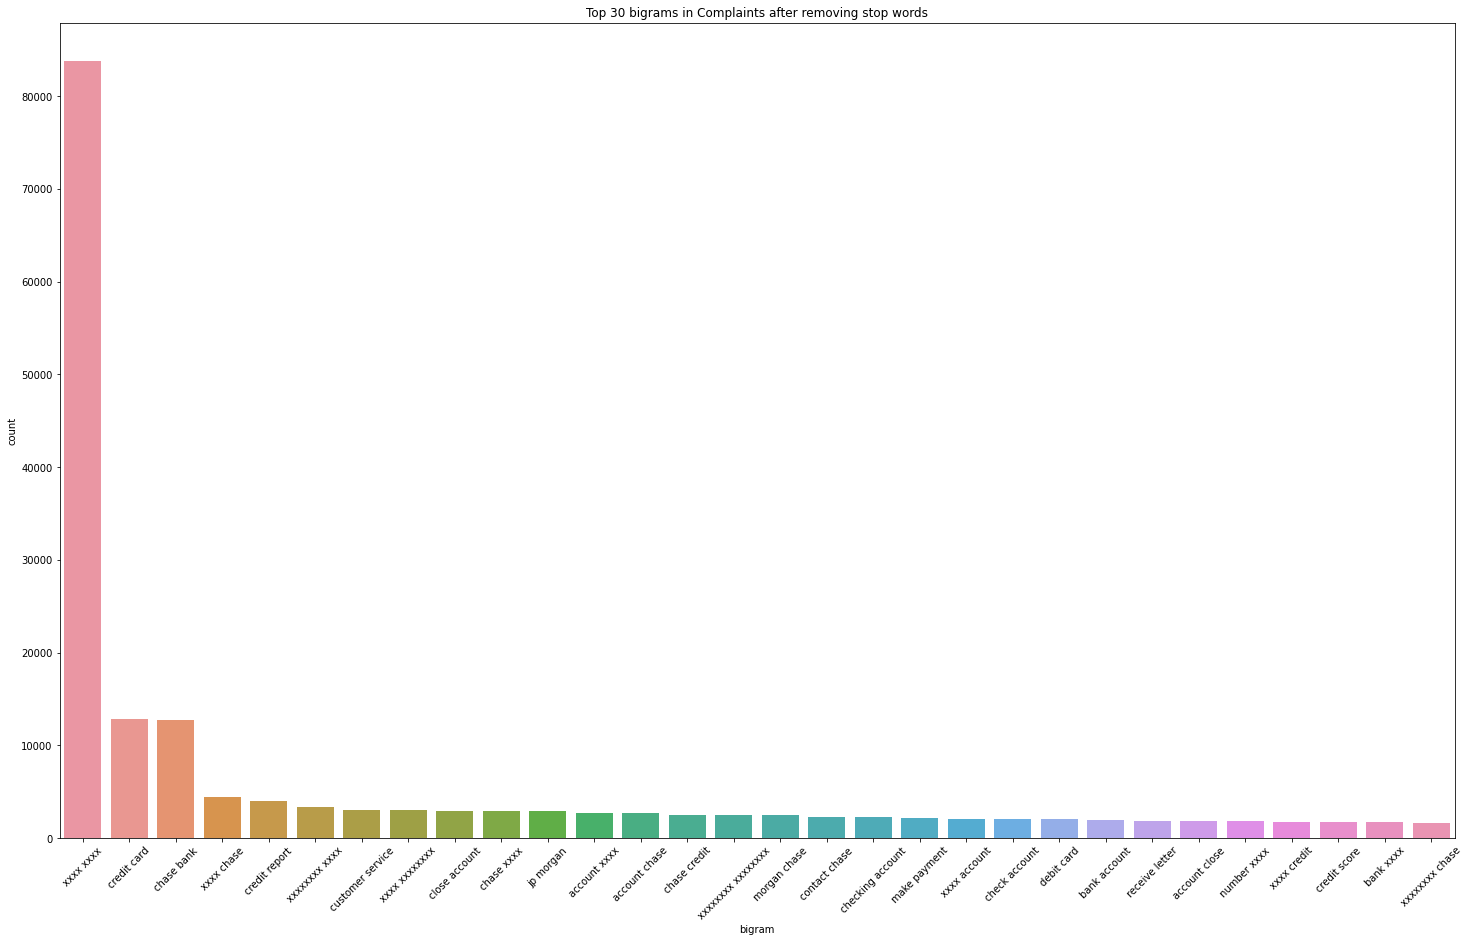

In [28]:
#top 30 bigram
common_words = get_top_n_ngram(df_clean.complaint_clean, 2, 30)
df2 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.title('Top 30 bigrams in Complaints after removing stop words')
plt.show()

In [29]:
#inspecting bigrams
df2.head(10)

,bigram,count
0,xxxx xxxx,83723
1,credit card,12812
2,chase bank,12780
3,xxxx chase,4446
4,credit report,3955
5,xxxxxxxx xxxx,3331
6,customer service,3066
7,xxxx xxxxxxxx,2989
8,close account,2953
9,chase xxxx,2951


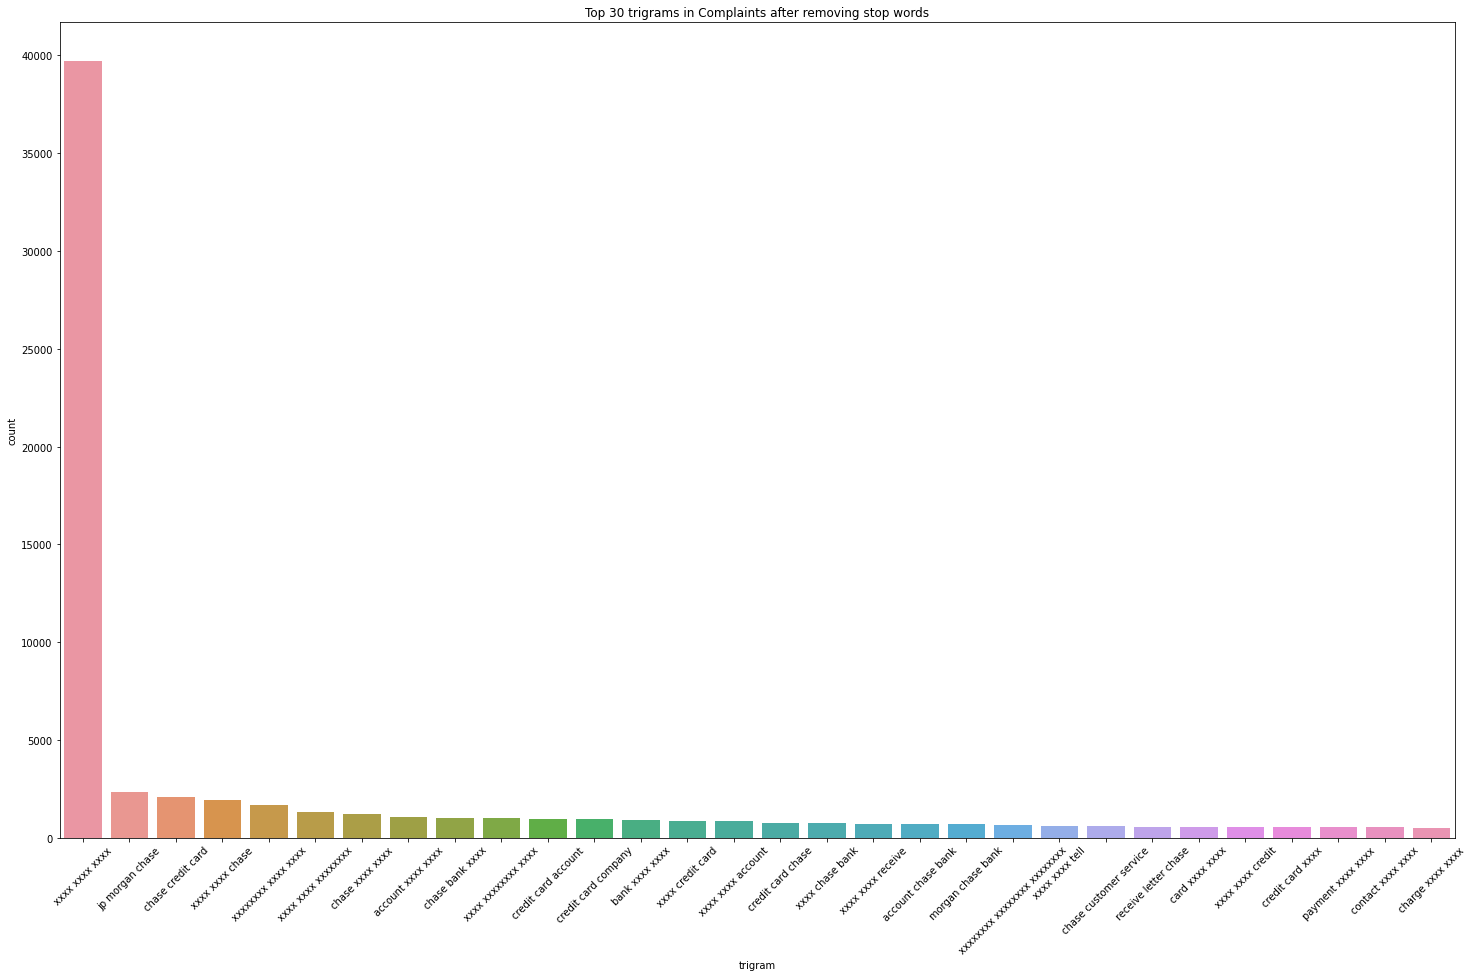

In [30]:
#top 30 trigrams 
common_words = get_top_n_ngram(df_clean.complaint_clean, 3, 30)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.title('Top 30 trigrams in Complaints after removing stop words')
plt.show()

In [31]:
#inspecting the 30 trigrams
df3.head(10)

,trigram,count
0,xxxx xxxx xxxx,39713
1,jp morgan chase,2349
2,chase credit card,2100
3,xxxx xxxx chase,1903
4,xxxxxxxx xxxx xxxx,1654
5,xxxx xxxx xxxxxxxx,1317
6,chase xxxx xxxx,1187
7,account xxxx xxxx,1052
8,chase bank xxxx,1013
9,xxxx xxxxxxxx xxxx,990


In [32]:
#removing the xxxx from personal details
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

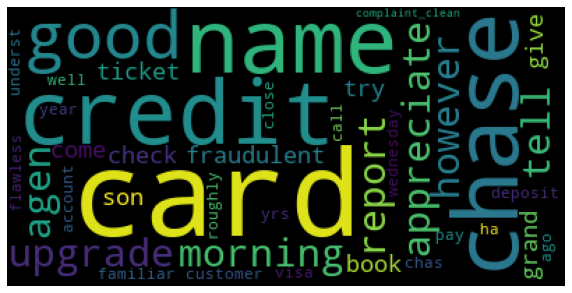

In [33]:
#usig the word cloud
wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_clean))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

#feature extraction


In [35]:
#using the TFIDF vectorization 
tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

In [36]:
#creating the document term matrix
dtm = tfidf.fit_transform(df_clean.complaint_clean)

#Topic Modelling using

In [37]:
#number of topics
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [38]:
#fiting the model
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

11996

In [39]:
#Top15 words for each topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words                

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,check,bank,chase,money,deposit,close,fund,tell,open,branch,say,day,checking,transfer
Topic 1,credit,report,card,inquiry,chase,hard,account,remove,apply,score,company,open,debt,information,close
Topic 2,loan,mortgage,chase,home,modification,property,letter,send,year,request,document,time,foreclosure,rate,bank
Topic 3,charge,card,chase,dispute,transaction,purchase,fee,refund,merchant,claim,receive,fraud,service,use,tell
Topic 4,payment,late,pay,make,balance,fee,month,statement,monthly,day,credit,account,chase,auto,time


In [40]:
#Create the best topic 
colnames = ["Topic {}".format(i) for i in range(nmf_model.n_components)]
complaintnames = ["Complaint{}".format(i) for i in range(len(df_clean.index))]
df_doc_topic = pd.DataFrame(W, columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_id'] = significant_topic


In [41]:
# assigning topic starting from 0, 1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)], index=[f'Complaint{i}' for i in range(W.shape[0])])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
Complaint0,0.021636,0.011077,0.037559,0.011166,0.002777,Topic 2
Complaint1,0.005409,0.006522,0.005017,0.009831,0.001032,Topic 3
Complaint2,0.000000,0.055278,0.003266,0.007794,0.000000,Topic 1
Complaint3,0.018323,0.055605,0.026241,0.017528,0.000000,Topic 1
Complaint4,0.063368,0.000000,0.003229,0.000000,0.002292,Topic 0
Complaint5,0.000000,0.072009,0.000000,0.000000,0.000000,Topic 1
Complaint6,0.056977,0.001963,0.009055,0.004615,0.016651,Topic 0
Complaint7,0.001874,0.000496,0.047913,0.009234,0.037389,Topic 2
Complaint8,0.025296,0.000000,0.026435,0.061276,0.000000,Topic 3
Complaint9,0.000000,0.107749,0.000015,0.004174,0.000000,Topic 1


In [42]:
#assigning the best topics
df_clean['Topic'] = W.max_topic.values

In [43]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account code xxxxxxxx terms account deposit bo...,403,i open an account with chase bank on and use ...,0,Topic 0
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund bank account money son ...,456,grand son give check for i deposit into ...,0,Topic 0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,notice account debit card branch customer serv...,2224,with out notice jp morgan chase restrict acco...,0,Topic 0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,account,50,mishandle of this account by chase auto and,0,Topic 0
35,i opened the saving account for the bonus i w...,i open the saving account for the bonus i be...,saving account bonus bonus auto transfers savi...,489,i open the saving account for the bonus i be...,0,Topic 0
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card application identity consent services cre...,210,chase card be report on however fraudulent a...,1,Topic 1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket rewards card information o...,1433,on while try to book a ticket i come a...,1,Topic 1
15,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,29,can please remove inquiry,1,Topic 1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card data credit report company i...,127,i have a chase credit card which be incorrectl...,1,Topic 1
26,i have reached out to xxxx several times in at...,i have reach out to xxxx several time in attem...,times attempt inquiry creditor inquiry report ...,735,i have reach out to several time in attempt t...,1,Topic 1


In [44]:
#creating the dictionary

Topic_names = {
    'Topic 0': 'Bank account services',
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 2': 'Mortgages/loans',
    'Topic 3': 'Theft/Dispute reporting',
    'Topic 4': 'Others'   
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

## Supervised model to predict


In [45]:
#Keep the columns"complaint_what_happened" & "topic_id"
training_data=df_clean[['complaint_what_happened', 'topic_id']]

In [46]:
# Split into train, validation
X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaint_what_happened, training_data.topic_id , train_size=0.8, random_state=40)


In [47]:
# We will be doing fit_transform   
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Transform the word vector to tf-idf
# We will be doing fit_transform  
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


In [48]:
#custom fucntion is for evaluating the confussion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
## confussion plot
def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            # Plot non-normalized confusion matrix
            class_names = [0,1,2,3,4]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix
                      , classes=class_names)                      
            plt.show()
      

In [52]:
#Function for training models and testing 
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    #Predict validation set:
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test_data, y_test_pred, plot)
    

In [53]:
#Using Decision Trees
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1001
           1       0.79      0.73      0.76       794
           2       0.61      0.87      0.72       836
           3       0.77      0.67      0.72      1137
           4       0.77      0.68      0.72       447

    accuracy                           0.74      4215
   macro avg       0.75      0.74      0.74      4215
weighted avg       0.75      0.74      0.74      4215

********************Confusion Matrix********************


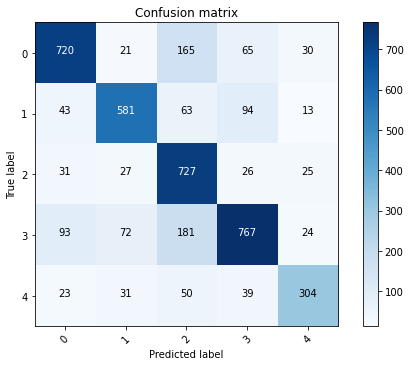

In [54]:
#Model fit on train and validate data
model_fit(dt,X_train, y_train, X_test, y_test ,True)

In [55]:
# Using Random Forest Model :
rfc = RandomForestClassifier(random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1001
           1       0.85      0.83      0.84       794
           2       0.88      0.84      0.86       836
           3       0.80      0.87      0.83      1137
           4       0.93      0.50      0.65       447

    accuracy                           0.83      4215
   macro avg       0.85      0.79      0.81      4215
weighted avg       0.84      0.83      0.83      4215

********************Confusion Matrix********************


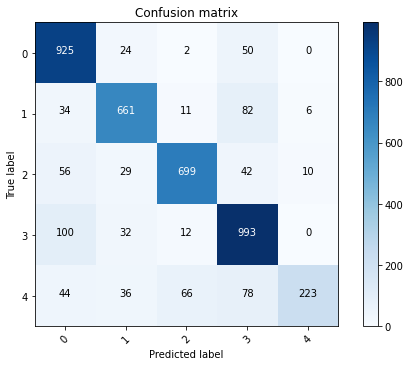

In [56]:
#Model fit on train and validate data
model_fit(rfc,X_train, y_train, X_test, y_test ,True)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1001
           1       0.87      0.55      0.67       794
           2       0.83      0.78      0.81       836
           3       0.59      0.94      0.72      1137
           4       1.00      0.03      0.05       447

    accuracy                           0.72      4215
   macro avg       0.82      0.63      0.62      4215
weighted avg       0.78      0.72      0.69      4215

********************Confusion Matrix********************


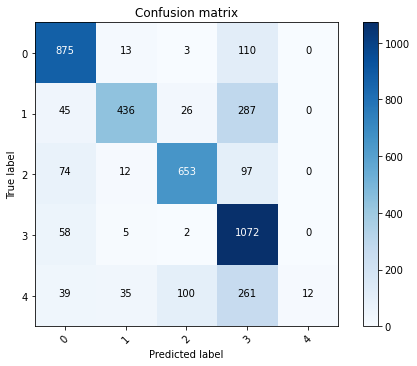

In [57]:
# Using multinomial Naive Bayes classifier
mnb = MultinomialNB()
#Model fit on train and test data
model_fit(mnb,X_train, y_train, X_test, y_test ,True)